In [1]:
import os
import time
import numpy as np 
import pandas as pd 
import datetime as dt 
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas_market_calendars as calen
from numpy import log as ln
from scipy.stats import norm
from pandas import DataFrame
from yahoo_fin import stock_info as si
from yahoo_fin import options
from scipy import misc

# Part 1. Data gathering component

1. Write a function (program) to connect to sources and download data from yahoo Finance.

2. With the function created in problem 1, download data on both options and equity for the following symbols:
    * AMAZ
    * SPY
    * VIX

3. Write a paragraph describing the symbols you are downloading data for explain what is the SPY and its purpose.

4. The followinf items will also need to be recorded:
    * The underlying equity or ETF price at the exact moment when the rest of the data is downloaded.
    * The short-term interest rate.
    * Time to Maturity

## Download Data from Yahoo

In [2]:
def download_data(path, name_list): 
    start = dt.datetime(2019,12,13) 
    end = dt.datetime(2020,8,31) 
    for name in name_list:
        data = web.DataReader(name,'yahoo',start,end) 
        data.to_csv(path + name + '.csv')

## Get Options Maturity

In [207]:
def get_maturi(name_list):
    maturi = []
    for name in name_list:
        data_option = options.get_expiration_dates(name)
        maturi.append(data_option)
    return(maturi)

## Get Stock Live Price

In [4]:
def live_data(name_list):
    prices = []
    for name in name_list:
        price = si.get_live_price(name)
        prices.append(price)
    live_price = pd.DataFrame({'Code':name_list, 'Live_Price':prices})
    return(live_price)

## Download Option Data

In [5]:
def download_options(maturi, name_list, path):
    for i in range(0,len(maturi)):
        list = maturi[i]
        name = name_list[i]
        for date in list:
            call = options.get_calls(name, date)
            call.to_csv(path + name + date + 'C.csv')
            put = options.get_puts(name, date)
            put.to_csv(path + name + date + 'P.csv')

In [6]:
if __name__ == "__main__":
    path = '/Users/yuechenjiang/Desktop/FE621/'
    name = input('Please enter stock codes and separate them with commas:\n')
    name_list = name.split(',')
    download_data(path, name_list)
    maturi = get_maturi(name_list)
    print(live_data(name_list))
    download_options(maturi, name_list, path)

Please enter stock codes and separate them with commas:
AMZN,SPY,^VIX
   Code   Live_Price
0  AMZN  3019.790039
1   SPY   323.420013
2  ^VIX    28.610001


In [208]:
print((len(maturi[0]), len(maturi[1]), len(maturi[2])))

(18, 32, 10)


Use the function "download_options(maturi, name_list, path)" once a day to collect day by day option data.

| Symbols       | Describing     |
| :------------- | :----------: |
| Contract Name | The name of each option whatever it belongs to index or stock. |
| Last Trade Day | The date of option was traded in most recently. |
| Strike price |The price level of each option which determines whether the option will be exercised. | 
| Last Trade Price | The price of option was traded in very recent day. |
| Ask | The lowest price that some one wants to buy the option. |
| Bid | The highest price that someone would like to sell the option. |
| Change | The absolute change of price of the option price, which only has number when the latest trade updated. |
| Percentage Change | The ratio of the price changes, which indicates the difference divided by the origin price. |
| Volume of Trade | Number of options that has been traded during a specific period. |
| Open Interest | Accumulated numbers of the option that has not been exercised. |
| Implied Volatility | This ratio measures the uncertainty of an option and the market, which links to Stock price. |
| Expire day | Expire day was shown in the name of each option and could be selected on websites. This date stands for the last trading day of exercising the options. |

**SPY:** SPY500 is one kind of ETF which contains a basket of stocks that covered the characteristic stocks all over the market. The purpose of this setting is to avoid most of the risk in the stock market, to keep implied volatility in a certain range.  

**VIX:** VIX is a number which gets the volatility from the S&P500 and give them weigh to reflect the volatility growth and dropping. VIX index option could be seen as a compensate of normal options. When VIX index going down, buyers would buy theoptions to make up the loss of VIX index option or the opposite. Thus. The purpose of VIXis till to prevent the risks that happened in the market.

**Observation Result: Relationship between AMZN SPY and VIX**  
AMZN is a single but unique stock in American stock market, which is also belongs to the S&P 500. Thus the goes up and down depends on the progress if each ingredient stock.VIX is a weighed summation of the implied volatility of  each stock in S&P 500. According to the observation, when AMZN and S&P 500 went up sometime, VIX would go down; when AMZN and S&P 500 went down sometime, VIX would go up.

# Part 2. Analysis of the data

5. Using your choice of computer programming language implement the Black-Scholes formulas as a function of current stock price $S_0$, volatility $\sigma$, time to expiration $T − t$ (in years), strike price $K$ and short-term interest rate $r$ (annual). Please note that no toolbox function is allowed but you may use the normal(CDF) calculation.

6. Implement the Bisection method to find the root of arbitrary functions. Apply this method to calculate the implied volatility on the first day you downloaded (DATA1). For this purpose use as the option value the average of bid and ask price if they both exist (and if their corresponding volume is nonzero). Also use a tolerance level of $10^{-6}$ Report the implied volatility at the money (for the option with strike price closest to the traded stock price). You need to do it for both the stock and the ETF data you have (you do not need to do this for VIX). Then average all the implied volatilties for the options between in-the-money and out-of-the-money.

7. Implement the Newton method/Secant method or Muller method to find the root of arbitrary functions. You will need to discover the formula for the option’s derivative with respect to the volatility $\sigma$. Apply these methods to the same options as in the previous problem. Compare the time it takes to get the root with the same level of accuracy.

## BS Formula

In [119]:
def bs_formula(S0,sigma,t,K,r,option_type):
    
    d1 = (ln(S0/K) + (r + (sigma**2)/2) * t)/(sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    
    if option_type==0:
        c = S0 * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
        return(c)
    elif option_type==1:
        p = K * np.exp(-r * t) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        return(p)

## Bisection method

In [120]:
def bisection_method(S0, K, r, t, op, option_type):
    tol = 10**(-7)
    maxiter = 10000
    sigma_low = 0
    sigma_high = 1
    for i in range(0,maxiter):
        sigma = (sigma_low + sigma_high)/2
        price = bs_formula(S0,sigma,t,K,r,option_type)
        test = price - op
        
        if abs(test) <= tol:
            return(sigma)
        else:
            if test < 0.0:
                sigma_low = sigma
            else:
                sigma_high = sigma
                
    return(sigma)

## Newton method

In [336]:
def NewtonsMethod(S0, r, t, op, K, option_type):
    tol = 10**(-6)
    sigma=0.0
    while abs(bs_formula(S0,sigma,t,K,r,option_type) - op) > tol:
        if option_type==0:
            if bs_formula(S0,sigma,t,K,r,option_type) > op:
                sigma-=tol
            else:
                sigma+=tol
        else:            
            if bs_formula(S0,sigma,t,K,r,option_type) < op:
                sigma-=tol
            else:
                sigma+=tol
    return(sigma)

In [335]:
def NewtonsMethod(S0, r, t, op, K, option_type):
    tol = 10**(-6)
    max = 10000
    ts = np.sqrt(t)
    sigma = (op/S0)/(0.398 * ts)
    for i in range(0,max):
        price = bs_formula(S0,sigma,t,K,r,option_type)
        diff = op - price
        if abs(diff) < tol:
            return(sigma)
        else:
            d1 = (log(S0/X) + (r + 0.5 * sigma**2)*t)/(sigma*np.sqrt(t))
            nd1 = 1/(sqrt(2 * np.pi)) * np.exp(-d1**2/2)
            vege = S0 * ts * nd1
            sigma = sigma + diff/vega

In [128]:
# this part substitute the test data to verify 
# whether the data calculated by the bisection method and Newton iteration method are the same
op = 1.875
S0 = 21
K = 20
r = 0.1
t = 0.25
print('The bisection method calculation call option result is:\n', bisection_method(S0, K, r, t, op, 0))
print('The newtons method calculation call option result is:\n', NewtonsMethod(S0, r, t, op, K, 0))

The bisection method calculation call option result is:
 0.23451292514801025


/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


The newtons method calculation call option result is:
 0.23451300000021386


The calculation results of dichotomy and Newton's iteration method are very close.

## Calculat Volatility 

In [34]:
def open_file(path, data):
    names = []
    for file in os.listdir(path + data):
        if '.csv' in file:
            names.append(file)
    return(names)

In [35]:
def add_column(path, data, names, price, day):
    nyse = calen.get_calendar('NYSE')
    
    start = time.time()
    for name in names:
        file = pd.read_csv(path + data + name)
        file['option price'] = 0.0
        file['moneyness'] = 'nan'
        file['bise_vol'] = 0.0
        file['newt_vol'] = 0.0
        file['S0'] = price

        for i in file.index:
            file['option price'][i] = (file['Bid'][i] + file['Ask'][i])/2

            if file['S0'][i]/file['Strike'][i] >= 0.95 and file['S0'][i]/file['Strike'][i] <= 1.05:
                file['moneyness'][i] = 'at the money'
            elif file['S0'][i]/file['Strike'][i] > 1.05:
                file['moneyness'][i] = 'in the money'
            else:
                file['moneyness'][i] = 'out of money'
            file.to_csv(day + name, index = False)
    
    delta_time = (time.time() - start) 
    print(delta_time)

In [129]:
 if __name__ == "__main__":
        live_price = live_data(name_list)
        amzn_price = live_price.iloc[0,1]
        spy_price = live_price.iloc[1,1]
        vix_price = live_price.iloc[2,1]
        amzn_name = open_file(path, 'DAY1AMZN/')
        print('Time cost of add colum of AMZN DAY1:') 
        add_column(path, 'DAY1AMZN/', amzn_name, amzn_price, 'day1') 
        spy_name = open_file(path, 'DAY1SPY/')
        print('Time cost of add colum of SPY DAY1:') 
        add_column(path, 'DAY1SPY/', spy_name, spy_price, 'day1') 
        # vix_name = open_file(path, 'DAY1VIX/')
        # print('Time cost of add colum of VIX DAY1:')
        # add_column(path, 'DAY1VIX/', vix_name, vix_price, 'day1')
        # amzn_name = open_file(path, 'DAY2AMZN/')
        # print('Time cost of add colum of AMZN DAY2:')
        # add_column(path, 'DAY1AMZN/', amzn_name, amzn_price, 'day2')
        # spy_name = open_file(path, 'DAY2SPY/')
        # print('Time cost of add colum of SPY DAY2:')
        # add_column(path, 'DAY1SPY/', spy_name, spy_price, 'day2')
        # vix_name = open_file(path, 'DAY2VIX/')
        # print('Time cost of add colum of VIX DAY2:')
        # add_column(path, 'DAY1VIX/', vix_name, vix_price, 'day2')

Time cost of add colum of AMZN DAY1:


/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/py

26.19404172897339
Time cost of add colum of SPY DAY1:
26.573400735855103


8. Present a table reporting the implied volatility values obtained for every maturity, option type and stock. Also compile the average volatilities as described in the previous point. Comment on the observed difference in values obtained for AMZN and SPY. Compare with the current value of the VIX. Comment on what happens when the maturity increases. Comment on what happen when the options become in the money respectively out of the money.

### Biesection Volatility

In [108]:
def bi_vol(path, data, names, dates, option_type):
    nyse = calen.get_calendar('NYSE')
    
    start = time.time()
    
    for name in names:
        file = pd.read_csv(path + data + name)
        for date in dates:
            schedule = nyse.schedule(start_date='2020-9-23', end_date=date)
            len(schedule)
            t = len(schedule)/252
            r = 1.58/100
            for i in file.index:
                S0 = file['S0'][i]
                K = file['Strike'][i]
                op = file['option price'][i]
                file['bise_vol'][i] = bisection_method(S0, K, r, t, op, option_type)
                file.to_csv(path + data + name, index=False)
    
    delta_time = (time.time() - start) 
    print(delta_time)

In [130]:
# Due to the large amount of the data, 
# this function is a test function. 
# There is only one Call Option data of Time to maturity on April 16, 2021 in the test folder. 
# After the test program is correct, use Google Colab to calculate all the data. 
def bi_vol(path, data, names, option_type):
    nyse = calen.get_calendar('NYSE')
    
    start = time.time()
    
    for name in names:
        file = pd.read_csv(path + data + name)
        schedule = nyse.schedule(start_date='2020-9-23', end_date='2021-4-16')
        len(schedule)
        t = len(schedule)/252
        r = 1.58/100
        for i in file.index:
            S0 = file['S0'][i]
            K = file['Strike'][i]
            op = file['option price'][i]
            file['bise_vol'][i] = bisection_method(S0, K, r, t, op, option_type)
            file.to_csv(path + data + name, index=False)
    
    delta_time = (time.time() - start) 
    print(delta_time)

### Newton Volatility

In [109]:
def nt_vol(path, data, names, dates, option_type):
    nyse = calen.get_calendar('NYSE')
    
    start = time.time()
    for name in names:
        file = pd.read_csv(path + data + name)
        for date in dates:
            schedule = nyse.schedule(start_date='2020-9-23', end_date=date)
            t = len(schedule)/252
            r = 1.58/100
            for i in file.index:
                S0 = file['S0'][i]
                K = file['Strike'][i]
                op = file['option price'][i]
                file['newt_vol'][i] = NewtonsMethod(S0, r, t, op, K, option_type)
                file.to_csv(path + data + name,index=False)
                
    delta_time = (time.time() - start) 
    print(delta_time)

In [131]:
# Due to the large amount of the data, 
# this function is a test function. 
# There is only one Call Option data of Time to maturity on April 16, 2021 in the test folder. 
# After the test program is correct, use Google Colab to calculate all the data.

def nt_vol(path, data, names, option_type):
    nyse = calen.get_calendar('NYSE')
    
    start = time.time()
    for name in names:
        file = pd.read_csv(path + data + name)
        schedule = nyse.schedule(start_date='2020-9-23', end_date='2021-4-16')
        t = len(schedule)/252
        r = 1.58/100
        for i in file.index:
            S0 = file['S0'][i]
            K = file['Strike'][i]
            op = file['option price'][i]
            file['newt_vol'][i] = NewtonsMethod(S0, r, t, op, K, option_type)
            file.to_csv(path + data + name,index=False)
                
    delta_time = (time.time() - start) 
    print(delta_time)

In [99]:
def vol_at_the_money(path, data, names):
    for name in names:
        file = pd.read_csv(path + data + name)
        a = file[file['moneyness']=='at the money']
        a = a[['Contract Name','moneyness','Implied Volatility','bise_vol']]
        a.to_csv(path + data + 'vol_at_the_money.csv',index=False)

### Average Volatility

In [105]:
def ave_vol(path, data, names, code):
    ave_in = []
    ave_out = []
        
    for name in names:
        file = pd.read_csv(path + data + name)
        in_m = file[file['moneyness']=='in the money']
        in_col = in_m['bise_vol']
        ave_in.append(np.mean(in_col))
        out_m = file[file['moneyness']=='out of money']
        out_col = out_m['bise_vol']
        ave_out.append(np.mean(out_col))
            
    d={'contract':names,'ave_in':ave_in,'ave_out':ave_out}
    ave_vola=pd.DataFrame(data=d) 
    ave_vola.to_csv(path + data + 'ave_vol.csv',index=False)

### Test function and Calculate AMZN Call Options.

In [137]:
# This part only run the test file to see if there is any bug in the function
# the bisection modle cost 26.359920024871826s
# the Newtons Method cost 0.5752570629119873s

if __name__ == "__main__":
    test = open_file(path, 'test')
    # at_amzn = open_file(path, 'at_amzn1c')
    # at_spy = open_file(path, 'at_spy1')
    # amzn_date = maturi[0]
    # spy_date = maturi[1]
    print('bisection cost time:')
    bi_vol(path, 'test/', test, 0)
    # bi_vol(path, data, names, dates, option_type)
    # bi_vol(path, 'at_amzn1c/', at_amzn, amzn_date, 0)
    # bi_vol(path, 'at_spy1/', at_spy, spy_date, 'day1')
    print('newton cost time:')
    nt_vol(path, 'test/', test, 0)
    # nt_vol(path, 'at_amzn1/', at_amzn, amzn_date, 'day1')
    # nt_vol(path, 'at_spy1/', at_spy, spy_date, 'day1')
    vol_at_the_money(path, 'test/', test)
    # vol_at_the_money(path, 'at_amzn1/', at_amzn)
    # vol_at_the_money(path, 'at_spy1/', at_spy)
    ave_vol(path, 'test/', ['day1AMZNApril 16, 2021C.csv'], 'AMZN')
    # ave_vol(path, 'at_amzn1/', at_amzn, 'AMZN')
    # ave_vol(path, 'at_spy1/', at_spy, 'SPY')

    
# test successed

bisection cost time:


/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


23.857665061950684
newton cost time:


/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.5628271102905273


In [ ]:
# After test we calculate the AMZN call options with different time to maturity, 
# others are finished in Google Colab.
if __name__ == "__main__":
    at_amzn = open_file(path, 'at_amzn1c')
    amzn_date = maturi[0]
    bi_vol(path, 'at_amzn1c/', at_amzn, amzn_date, 0)
    nt_vol(path, 'at_amzn1c/', at_amzn, amzn_date, 'day1')
    vol_at_the_money(path, 'at_amzn1c/', at_amzn)
    ave_vol(path, 'at_amzn1c/', at_amzn, 'AMZN')

When the transaction volume is large, the implied volatility calculated by the bisection and Newton iteration method is closer to the actual value. The efficiency of the Newton iteration method is higher than that of the dichotomy method, but there are cases where the iteration does not produce results, so The following volatility curve is drawn using the implied volatility calculated by dichotomy.

## Put-Call parity

9. For each option in your table calculate the price of the different type (Call/Put) using the Put-Call parity. Compare the resulting values with the BID/ASK values for the corre- sponding option if they exist.

In [225]:
def put_call(path, data, dates, code):
    nyse = calen.get_calendar('NYSE')
    
    call_names = []
    for file in os.listdir(path + data):
        if 'C.csv' in file:
            call_names.append(file)
            
    for name in call_names:
        file_call=pd.read_csv(path + data + name)
        file_call['Parity_call']=np.nan
    
    put_names = []
    for file in os.listdir(path + data):
        if 'P.csv' in file:
            put_names.append(file)
            
    for name in put_names:
        file_put=pd.read_csv(path + data + name)
        file_put['Parity_put']=np.nan
        
    for date in dates:    
        schedule = nyse.schedule(start_date='2020-9-23', end_date=date)
        len(schedule)
        t=len(schedule)/252
        r=1.58/100
        for i in range(min(len(file_call),len(file_put))):
            K=file_call['Strike'][i]
            S0=file_call['S0'][i]  
            file_call['Parity_call'][i]=max(file_put['option price'][i]+S0-K*np.exp(-r*t),0)
            file_put['Parity_put'][i]=max(file_call['option price'][i]+K*np.exp(-r*t)-S0,0)
            c={'Contract Name':file_call['Contract Name'],'Bid':file_call['Bid'],'Ask':file_call['Ask'], 'option price':file_call['option price'],'Parity call':file_call['Parity_call']}
            callfile=pd.DataFrame(data=c) 
            callfile.to_csv(code + 'Parity_call_' + date + '.csv', index=False)
            p={'Contract Name':file_put['Contract Name'],'Bid':file_put['Bid'],'Ask':file_put['Ask'],'option price':file_put['option price'],'Parity put':file_put['Parity_put']}
            putfile=pd.DataFrame(data=p)
            putfile.to_csv(code + 'Parity_put_' + date + '.csv', index=False)

In [229]:
if __name__ == "__main__":
    put_call(path, 'at_amzn1/', maturi[0], 'AMZN')
    put_call(path, 'at_spy1/', maturi[1], 'SPY')

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/pytho

There are part of the file of put-call parity table. All files see zip file.

In [230]:
call_amzn = pd.read_csv('AMZNParity_call_September 25, 2020.csv')
call_amzn

,Contract Name,Bid,Ask,option price,Parity call
0,AMZN210716C01520000,0.0,0.0,0.0,1500.075917
1,AMZN210716C01800000,0.0,0.0,0.0,1220.128579
2,AMZN210716C01860000,0.0,0.0,0.0,1160.139863
3,AMZN210716C01940000,0.0,0.0,0.0,1080.154910
4,AMZN210716C01980000,0.0,0.0,0.0,1040.162433
...,...,...,...,...,...
56,AMZN210716C05050000,0.0,0.0,0.0,0.000000
57,AMZN210716C05100000,0.0,0.0,0.0,0.000000
58,AMZN210716C05200000,0.0,0.0,0.0,0.000000
59,AMZN210716C05250000,0.0,0.0,0.0,0.000000


In [233]:
put_amzn = pd.read_csv('AMZNParity_put_September 25, 2020.csv')
put_amzn

,Contract Name,Bid,Ask,option price,Parity put
0,AMZN210820P01500000,0.0,0.0,0.0,0.0
1,AMZN210820P01600000,0.0,0.0,0.0,0.0
2,AMZN210820P01620000,0.0,0.0,0.0,0.0
3,AMZN210820P01640000,0.0,0.0,0.0,0.0
4,AMZN210820P01660000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
67,AMZN210820P04500000,0.0,0.0,0.0,NaN
68,AMZN210820P04600000,0.0,0.0,0.0,NaN
69,AMZN210820P05000000,0.0,0.0,0.0,NaN
70,AMZN210820P05100000,0.0,0.0,0.0,NaN


In [234]:
call_amzn = pd.read_csv('SPYParity_call_September 30, 2020.csv')
call_amzn

,Contract Name,Bid,Ask,option price,Parity call
0,SPY210618C00100000,0.00,0.00,0.000,228.767623
1,SPY210618C00110000,214.40,215.71,215.055,218.771384
2,SPY210618C00115000,0.00,0.00,0.000,213.773265
3,SPY210618C00120000,0.00,0.00,0.000,208.775145
4,SPY210618C00125000,199.61,200.81,200.210,203.777026
...,...,...,...,...,...
156,SPY210618C00510000,0.00,0.00,0.000,NaN
157,SPY210618C00515000,0.00,0.00,0.000,NaN
158,SPY210618C00520000,0.00,0.00,0.000,NaN
159,SPY210618C00525000,0.00,0.00,0.000,NaN


In [235]:
put_spy = pd.read_csv('SPYParity_put_September 30, 2020.csv')
put_spy

,Contract Name,Bid,Ask,option price,Parity put
0,SPY201019P00210000,0.0,0.0,0.0,0.000000
1,SPY201019P00215000,0.0,0.0,0.0,0.000000
2,SPY201019P00220000,0.0,0.0,0.0,0.000000
3,SPY201019P00225000,0.0,0.0,0.0,0.000000
4,SPY201019P00230000,0.0,0.0,0.0,0.000000
5,SPY201019P00235000,0.0,0.0,0.0,0.000000
6,SPY201019P00240000,0.0,0.0,0.0,0.000000
7,SPY201019P00245000,0.0,0.0,0.0,0.000000
8,SPY201019P00250000,0.0,0.0,0.0,0.000000
9,SPY201019P00255000,0.0,0.0,0.0,0.000000


## Volatility Smile close to time to maturity options

10. Consider the implied volatility values obtained in the previous parts. Create a 2 dimensional plot of implied volatilities versus strike K for the closest to maturity options. What do you observe? Plot all implied volatilities for the three different maturities on the same plot, where you use a different color for each maturity. In total there should be 3 sets of points plotted with different color. 

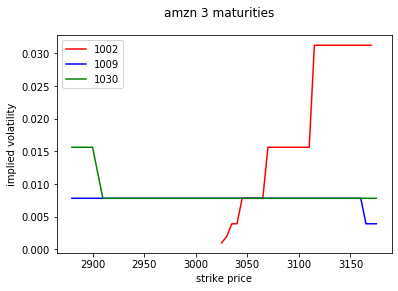

In [200]:
#Plot all implied volatilities for the three different maturities on the same plot

file=pd.read_csv('day1AMZNOctober 2, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'r')

file=pd.read_csv('day1AMZNOctober 9, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'b')

file=pd.read_csv('day1AMZNOctober 30, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'g')

plt.legend(labels=['1002','1009','1030'])


plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.suptitle('amzn 3 maturities')

plt.show()

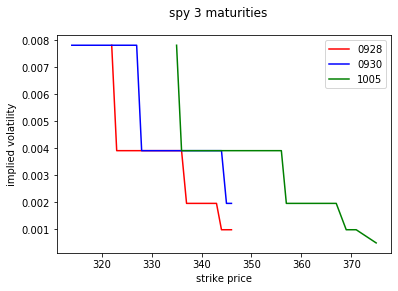

In [204]:
##spy 3 maturities plot

file=pd.read_csv('day1SPYSeptember 28, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'r')

file=pd.read_csv('day1SPYSeptember 30, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'b')

file=pd.read_csv('day1SPYOctober 5, 2020C.csv')
a=file.dropna(how='any',subset=['bise_vol'])
plt.plot(a['Strike'],a['bise_vol'],'g')

plt.legend(labels=['0928','0930','1005'])


plt.xlabel('strike price')
plt.ylabel('implied volatility')
plt.suptitle('spy 3 maturities')

plt.show()

## Greek of Amzn and SPY

11.  (Greeks) Calculate the derivatives of the call option price with respect to $S$ (Delta), and $\sigma$ (Vega) and the second derivative with respect to $S$ (Gamma). First use the Black Scholes formula then approximate these derivatives using an approximation of the partial derivatives. Compare the numbers obtained by the two methods. Output a table containing all derivatives thus calculated.

In [264]:
def N1(x):
    return  np.exp(-x**2/2)/(np.sqrt(2*np.pi))


def delta_bs(d1,sigma):
    return norm.cdf(d1)

def vega_bs(d1,sigma):
    return S0*np.sqrt(t)*N1(d1)
    
def gamma_bs(d1,sigma):
    return N1(d1)/(S0*sigma*np.sqrt(t))

def delta_numeri(S0,sigma):
    return (bs_formula(S0+0.01,sigma,t,K,r,option_type)-bs_formula(S0,sigma,t,K,r,option_type))/0.01
       
def vega_numeri(sigma):
    return (bs_formula(S0,sigma+0.0001,t,K,r,option_type)-bs_formula(S0,sigma,t,K,r,option_type))/0.0001

def gamma_numeri(S0,sigma):
    return (delta_numeri(S0+0.01,sigma)-delta_numeri(S0,sigma))/0.01

In [270]:
def greek(path, data, dates, code):
    nyse = calen.get_calendar('NYSE')
    
    names = []
    for file in os.listdir(path + data):
        if 'C.csv' in file:
            names.append(file)
            
    for name in names:
        file = pd.read_csv(path + data + name)
        file=file.dropna(how='any',subset=['bise_vol'])
        file['delta_bs']=np.nan
        file['delta_numeri']=np.nan
        file['vega_bs']=np.nan
        file['vega_numeri']=np.nan
        file['gamma_bs']=np.nan
        file['gamma_numeri']=np.nan
    
    for date in dates:
        schedule = nyse.schedule(start_date='2020-2-10', end_date=date)
        len(schedule)
        t=len(schedule)/252
        r=1.58/100
        option_type=0
    
    for i in file.index:
        K=file['Strike'][i]
        S0=file['S0'][i]
        sigma=file['bise_vol'][i]
        
        d1=(ln(S0/K)+(r+(sigma**2)/2)*t)/(sigma*np.sqrt(t))
        d2=d1-(sigma*np.sqrt(t))
        
        file['delta_bs'][i]=delta_bs(d1,sigma)
        file['delta_numeri'][i]=delta_numeri(S0, sigma)
        file['vega_bs'][i]=vega_bs(d1,sigma)
        file['vega_numeri'][i]=vega_numeri(sigma)
        file['gamma_bs'][i]=gamma_bs(d1,sigma)
        file['gamma_numeri'][i]=gamma_numeri(S0,sigma)
        d={'Contract Name':file['Contract Name'],'Strike':file['Strike'],'S0':file['S0'],'option price':file['option price'],'bise_vol':file['bise_vol'],'delta_bs':file['delta_bs'],'delta_numeri':file['delta_numeri'],'vega_bs':file['vega_bs'],'vega_numeri':file['vega_numeri'],'gamma_bs':file['gamma_bs'],'gamma_numeri':file['gamma_numeri']}
        file=pd.DataFrame(data=d) 
        file.to_csv('Greek'+ code + date + '.csv',index=False)

In [274]:
if __name__ == "__main__":
    greek(path, 'at_amzn1/', maturi[0], 'AMZN')
    greek(path, 'at_spy1/', maturi[1], 'SPY')

/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yuechenjiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

There are part of the file of put-call parity table. All files see zip file.

In [273]:
greek_amzn = pd.read_csv('GreekAMZNJanuary 20, 2023.csv')
greek_amzn

,Contract Name,Strike,S0,option price,bise_vol,delta_bs,delta_numeri,vega_bs,vega_numeri,gamma_bs,gamma_numeri
0,AMZN210716C01520000,1520.0,3019.790039,0.0,0.0,1.0,-1.0,0.0,0.0,NaN,0.0
1,AMZN210716C01800000,1800.0,3019.790039,0.0,0.0,1.0,-1.0,0.0,0.0,NaN,0.0
2,AMZN210716C01860000,1860.0,3019.790039,0.0,0.0,1.0,-1.0,0.0,0.0,NaN,0.0
3,AMZN210716C01940000,1940.0,3019.790039,0.0,0.0,1.0,-1.0,0.0,0.0,NaN,0.0
4,AMZN210716C01980000,1980.0,3019.790039,0.0,0.0,1.0,-1.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
56,AMZN210716C05050000,5050.0,3019.790039,0.0,0.0,0.0,-1.0,0.0,0.0,NaN,0.0
57,AMZN210716C05100000,5100.0,3019.790039,0.0,0.0,0.0,-1.0,0.0,0.0,NaN,0.0
58,AMZN210716C05200000,5200.0,3019.790039,0.0,0.0,0.0,-1.0,0.0,0.0,NaN,0.0
59,AMZN210716C05250000,5250.0,3019.790039,0.0,0.0,0.0,-1.0,0.0,0.0,NaN,0.0


In [275]:
greek_spy = pd.read_csv('GreekSPYJanuary 20, 2023.csv')
greek_spy

,Contract Name,Strike,S0,option price,bise_vol,delta_bs,delta_numeri,vega_bs,vega_numeri,gamma_bs,gamma_numeri
0,SPY210618C00100000,100.0,328.730011,0.000,0.0,1.0,-1.0,0.0,0.0,NaN,4.547474e-09
1,SPY210618C00110000,110.0,328.730011,215.055,0.0,1.0,-1.0,0.0,0.0,NaN,4.547474e-09
2,SPY210618C00115000,115.0,328.730011,0.000,0.0,1.0,-1.0,0.0,0.0,NaN,4.547474e-09
3,SPY210618C00120000,120.0,328.730011,0.000,0.0,1.0,-1.0,0.0,0.0,NaN,4.547474e-09
4,SPY210618C00125000,125.0,328.730011,200.210,0.0,1.0,-1.0,0.0,0.0,NaN,4.547474e-09
...,...,...,...,...,...,...,...,...,...,...,...
156,SPY210618C00510000,510.0,328.730011,0.000,0.0,0.0,-1.0,0.0,0.0,NaN,4.547474e-09
157,SPY210618C00515000,515.0,328.730011,0.000,0.0,0.0,-1.0,0.0,0.0,NaN,4.547474e-09
158,SPY210618C00520000,520.0,328.730011,0.000,0.0,0.0,-1.0,0.0,0.0,NaN,4.547474e-09
159,SPY210618C00525000,525.0,328.730011,0.000,0.0,0.0,-1.0,0.0,0.0,NaN,4.547474e-09


12. Next we will use the second dataset DATA2. For each strike price in the data use the Stock price for the same day, the implied volatility you calculated from DATA1 and the current short-term interest rate (corresponding to the day on which DATA2 was gathered). Use the Black-Scholes formula, to calculate the option price.

In [299]:
def bs_price(path, data1, data2, names1, names2, dates, price, option_type):
    nyse = calen.get_calendar('NYSE')
     
    for name in names1:
        file1=pd.read_csv(path + data1 + name)
        file1=file1.dropna(how='any',subset=['bise_vol'])
        for name in names2:
            file2=pd.read_csv(path + data2 + name)

            file2['S0'] = price
            file2['option price']=np.nan
        
            for date in dates:
                schedule = nyse.schedule(start_date='2020-9-23', end_date=date)
                len(schedule)
                t=len(schedule)/252
                r=1.58/100
                for i in file2.index:
                    K=file2['Strike'][i]
                    file2['option price'][i]=(file2['Bid'][i]+file2['Ask'][i])/2
                    sigma=file1['bise_vol'][i]
                    file2['option price'][i]=bs_formula(price,sigma,t,K,r,option_type)
        
                    file2=file2.dropna(how='any',subset=['option price'])   
                    d={'Contract Name':file2['Contract Name'],'Strike':file2['Strike'],'S0':file2['S0'],'Bid':file2['Bid'],'Ask':file2['Ask'],'option price':file2['option price']}
                    file2=pd.DataFrame(data=d)  
                    file2.to_csv('bs_price_amzn_' + name,index=False)

There are part of the file of put-call parity table. All files see zip file.

In [333]:
amzn = pd.read_csv('bs_price_amzn.csv')
amzn

,Contract Name,Strike,S0,Bid,Ask,option price
0,AMZN200925C03075000,3075,3095.129883,13.70,14.40,8.640000e-220
1,AMZN200925C03080000,3080,3095.129883,11.35,12.35,7.210000e-128
2,AMZN200925C03085000,3085,3095.129883,11.20,12.10,3.460000e-61
3,AMZN200925C03090000,3090,3095.129883,10.30,10.85,1.650000e-19
4,AMZN200925C03095000,3095,3095.129883,8.65,9.35,4.711331e-02
...,...,...,...,...,...,...
137,AMZN200925C04600000,4600,3095.129883,0.00,0.01,1.504005e+03
138,AMZN200925C04700000,4700,3095.129883,0.00,0.01,1.603986e+03
139,AMZN200925C04800000,4800,3095.129883,0.00,0.01,1.703967e+03
140,AMZN200925C04900000,4900,3095.129883,0.00,0.00,1.803949e+03


In [334]:
spy = pd.read_csv('bs_price_spy.csv')
spy

,Contract Name,Strike,S0,Bid,Ask,option price
0,SPY200930C00185000,185.0,3095.129883,155.01,155.38,7.978912e-147
1,SPY200930C00190000,190.0,3095.129883,133.71,134.17,0.000000e+00
2,SPY200930C00195000,195.0,3095.129883,136.04,137.07,1.949545e-141
3,SPY200930C00199000,199.0,3095.129883,125.92,126.67,4.993843e-144
4,SPY200930C00200000,200.0,3095.129883,123.55,124.00,0.000000e+00
...,...,...,...,...,...,...
189,SPY200930C00405000,405.0,3095.129883,0.00,0.01,0.000000e+00
190,SPY200930C00410000,410.0,3095.129883,0.00,0.01,0.000000e+00
191,SPY200930C00415000,415.0,3095.129883,0.00,0.01,0.000000e+00
192,SPY200930C00420000,420.0,3095.129883,0.00,0.01,0.000000e+00


# Part 3. Numerical Integration of real-valued functions.

Consider the real-valued function:
$$
f(x)
\begin{cases}
\cfrac {sin(x)} x, &for\ x\ \neq\ 0,\\
1, &for\ x\ =\ 0.
\end{cases}
$$
Note that we can actually calculate this integral as: $\int^{\infty}_{-\infty}f(x)dx = \pi$

In [17]:
def f(x):
    if x !=0:
        return np.sin(x)/x
    else:
        return 1

1. Implement the trapezoidal and the Simpson’s quadrature rules to numerically approximate the indefinite integral above.

In [18]:
#trapezoidal
def trapezoidal(a,N):
    dx = 2 * a / N
    integ = (f(-a) + f(a)) * dx/2
    for i in range(1,N):
        integ+=dx * f(-a + i * dx)
    return(integ)

In [19]:
def simpson(a,N):
     dx = 2 * a / N
     even_item = 0
     odd_item = 0
     for j in range(1,int(N/2)):
        even_item+=f(-a + 2 * j * 2 * a/N)
                    
     for j in range(1,int(N/2) + 1):
        odd_item+=f(-a + (2 * j - 1) * 2 * a/N)  
                  
              
     integ = even_item * 4 * dx/3 + odd_item * 2 * dx/3 + f(-a) * dx/3 + f(a) * dx/3

     return(integ)

2. Compute the truncation error for the numerical algorithms implemented in 1. for a particular $\alpha$ ∈ R and $ N$ ∈ N. That is,create a functiono f $\alpha$ and $N$ that will output $I_N -\pi$, where $I_{N,\alpha}$ is the numerical approximation of the integral. Study the changes in the approximation as $N$ and $\alpha$ increase as well as the difference between the two quadrature approximations. Please write your observations.

Observation:
Truncation error will decrease when $\alpha$ or $N$ increase. And when fix $\alpha$ and increase $N$, simpson error is larger than that of trapezoidal method. (See image below)

In [20]:
def trape_error(a,N):
    return(trapezoidal(a,N) - np.pi)

#fix a and increase N
def fix_trape_N(a):
    numbers=[]
    list=[]
    for n in range(1,500):
        N=1000*n
        numbers.append(N)
        list.append(trape_error(a,N))
    data = pd.DataFrame({'Numbers':numbers, 'Trape_Error':list})
    return(data)

In [21]:
def simpson_error(a,N):
    return(simpson(a,N) - np.pi)

#fix a and increase N
def fix_simpson_N(a):
    numbers=[]
    list=[]
    for n in range(1,500):
        N=1000*n
        numbers.append(N)
        list.append(simpson_error(a,N))
    data = pd.DataFrame({'Numbers':numbers, 'Simpson_Error':list})
    return(data)

In [22]:
#fix N and increase a
def fix_trape_a(N):
    numbers=[]
    list=[]
    for i in range(1,500):
        a=1000*i
        numbers.append(a)
        list.append(trape_error(a,N))
    data = pd.DataFrame({'Inte_Interval':numbers, 'Trape_Error':list})
    return(data)

In [23]:
#fix N and increase a
def fix_trape_a(N):
    numbers=[]
    list=[]
    for i in range(1,500):
        a=1000*i
        numbers.append(a)
        list.append(simpson_error(a,N))
    data = pd.DataFrame({'Inte_Interval':numbers, 'Simpson_Error':list})
    return(data)

3. In a typical scenario we do not know the true value of the integral. Thus, to ensure the convergence of the numerical algorithms we pick a small tolerance value $\xi$ and we check at every iteration $k = 1,2,\cdots$ if the following condition holds:
$$
| I_k - I_{k-1} | < \xi,
$$
where $I_k$ is the value of the integral at step $k$. When the condition holds,, the algorithm stops.Evaluate the number of steps until the algorithms from a) reach convergence for $\xi = 10^{-4}$. what do you observe?

In [24]:
def trape_time(a, tol, k):
    while True:
        delta=abs(trapezoidal(a,k+1)-trapezoidal(a,k))
        if delta<tol:
            return(k+1)
            break
        k+=1

In [25]:
def simp_time(a, tol, k):
    while True:
        delta = abs(simpson(a,k+1)-simpson(a,k))
        if delta<tol:
            return(k+1)
            break
        k+=1

In [26]:
if __name__ == "__main__":
    print('Trapezoidal’s quadrature rules:',trapezoidal(10**6,3000000))
    print('Simpson’s quadrature rules:', simpson(10**6,1000000))
    print('Times of trape is:', trape_time(10**6, 10**(-4), 318380))
    print('Times of simpson is', simp_time(10**6, 10**(-4), 640660))
    a = fix_trape_N(10**6)
    b = fix_simpson_N(10**6)
    c = fix_trape_a(500000)
    d = fix_trape_a(500000)

Trapezoidal’s quadrature rules: 3.1415908499948566
Simpson’s quadrature rules: 3.1415928898896732
Times of trape is: 318388
Times of simpson is 640668


So, simpson converge slower than that of trape.

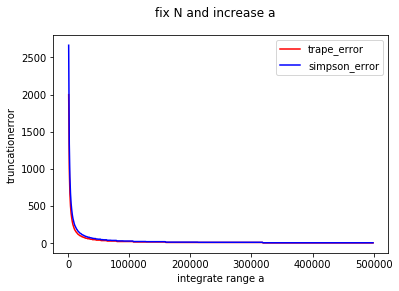

In [27]:
plt.plot(a.iloc[:,0],a.iloc[:,1],'r')
plt.plot(b.iloc[:,0],b.iloc[:,1],'b')

plt.legend(labels=['trape_error','simpson_error'])


plt.xlabel('integrate range a')
plt.ylabel('truncationerror')
plt.suptitle('fix N and increase a')

plt.show()

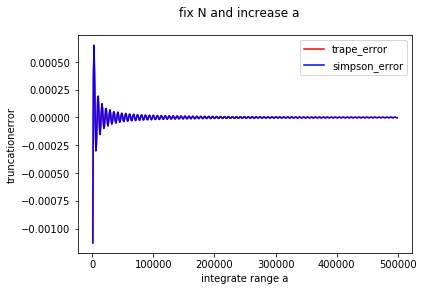

In [28]:
plt.plot(c.iloc[:,0],c.iloc[:,1],'r')
plt.plot(d.iloc[:,0],d.iloc[:,1],'b')

plt.legend(labels=['trape_error','simpson_error'])


plt.xlabel('integrate range a')
plt.ylabel('truncationerror')
plt.suptitle('fix N and increase a')

plt.show()

# Part4. Condider the following functions

1.  
The integration of $f_1(x,y)$ is 2.25  
The integration of $f_2(x,y)$ is $(e-1) \times (e^3-1)= 32.79433128149753$

In [29]:
-(np.exp(1)-1)*(np.exp(3)-1)

-32.79433128149753

2. Calculate the numerical integral of the f1 and f2 by applying the trape- zoidal rule for double integral

In [30]:
def f1(x,y):
    return x*y

def f2(x,y):
    return np.exp(x+y)

In [31]:
def trape_double(f,n,m):
    dx = 1/(n + 1)
    dy = 3/(m + 1)
    result=0
    def x(i):
        return i * dx
    def y(j):
        return j * dy
    
    for i in range(n + 1):
        for j in range(m + 1):
            result+=f(x(i),y(j)) + f(x(i),y(j + 1)) + f(x(i + 1), y(j)) + f(x(i + 1), y(j + 1)) + 2 * (f((x(i) + x(i + 1))/2, y(j)) + f((x(i) + x(i + 1))/2,y(j + 1)) + f(x(i),(y(j) + y(j + 1))/2) + f(x(j + 1), (y(j) + y(j + 1))/2)) + 4 * f((x(i) + x(i + 1))/2, (y(j) + y(j + 1))/2)
       
    return (dx * dy * result/16)

In [32]:
if __name__ == "__main__":
    m1 = 30
    n1 = 10

    m2 = 90
    n2 = 30

    m3 = 270
    n3 = 90

    m4 = 300
    n4 = 100

    m_list = [m1,m2,m3,m4]
    n_list = [n1,n2,n3,n4]
    approx_f1_list = [trape_double(f1,n1,m1), trape_double(f1,n2,m2), trape_double(f1,n3,m3), trape_double(f1,n4,m4)]
    erro_f1_list = [trape_double(f1,n1,m1) - 2.25, trape_double(f1,n2,m2) - 2.25, trape_double(f1,n3,m3) - 2.25, trape_double(f1,n4,m4) - 2.25]

    approx_f2_list = [trape_double(f2,n1,m1), trape_double(f2,n2,m2), trape_double(f2,n3,m3), trape_double(f2,n4,m4)]
    erro_f2_list = [trape_double(f2,n1,m1) - (np.exp(1) - 1) * (np.exp(3) - 1), trape_double(f2,n2,m2) - (np.exp(1) - 1) * (np.exp(3) - 1), trape_double(f2,n3,m3) - (np.exp(1) - 1) * (np.exp(3) - 1), trape_double(f2,n4,m4) - (np.exp(1) - 1) * (np.exp(3) - 1)]

    form = pd.DataFrame({'n':n_list, 'm':m_list, 'approx_f1':approx_f1_list, 'erro_f1':erro_f1_list, 'approx_f2':approx_f2_list, 'erro_f2':erro_f2_list})  
    print(form)

     n    m  approx_f1   erro_f1  approx_f2    erro_f2
0   10   30   3.025293  0.775293  51.106606  18.312274
1   30   90   3.069523  0.819523  52.846132  20.051801
2   90  270   3.085504  0.835504  53.502354  20.708022
3  100  300   3.086321  0.836321  53.536295  20.741963


After calculated four approximation result and errors. We can observe from the result from above that the approximation method for double integration has lager error than that of single integration.